## (i) Importing the necessary packages

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,BatchNormalization,MaxPooling2D,Reshape
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [2]:
import sys
runningOnColab = 'google.colab' in sys.modules
if runningOnColab:
  from google.colab import drive
  drive.mount('/content/drive')
  %cd '/content/drive/Shareddrives/ECE247/Project'

Mounted at /content/drive
/content/drive/Shareddrives/ECE247/Project


## (ii) Preprocessing the dataset and preparing the training, validation, and test datasets

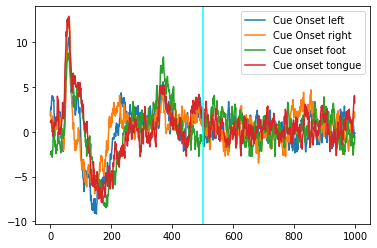

In [3]:
## Loading and visualizing the data

## Loading the dataset


X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

person_train_valid = np.squeeze(person_train_valid)
person_test = np.squeeze(person_test)

indices = person_train_valid == 0
indices = indices.flatten()
y_train_valid = y_train_valid[indices]
X_train_valid = X_train_valid[indices]
person_train_valid = person_train_valid[indices]

indices = person_test == 0 
indices = indices.flatten()
y_test = y_test[indices]
X_test = X_test[indices]
person_test = person_test[indices]

## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

## Visualizing the data

ch_data = X_train_valid[:,8,:]


class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])





![EEG_prep.png](attachment:EEG_prep.png)

In [4]:
def data_prep(X, y, person, sub_sample, average, noise):
    
    total_X = None
    total_y = None
    total_person = None

    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:500]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    total_person = person
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    total_person = np.hstack((total_person, person))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        total_person = np.hstack((total_person, person))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    return total_X, total_y, total_person 

X_train_valid_prep, y_train_valid_prep, person_train_valid_prep = data_prep(X_train_valid, y_train_valid, person_train_valid, 2, 2, True)


Shape of X after trimming: (237, 22, 500)
Shape of X after maxpooling: (237, 22, 250)
Shape of X after averaging+noise and concatenating: (474, 22, 250)
Shape of X after subsampling and concatenating: (948, 22, 250)


In [5]:

## Preprocessing the dataset

X_train_valid_prep, y_train_valid_prep, person_train_valid_prep = data_prep(X_train_valid, y_train_valid, person_train_valid, 2, 2, True)
X_test_prep, y_test_prep, person_test_prep = data_prep(X_test, y_test, person_test, 2, 2, True)

print(X_train_valid_prep.shape)
print(y_train_valid_prep.shape)
print(person_train_valid_prep.shape)
print(X_test_prep.shape)
print(y_test_prep.shape)
print(person_test_prep.shape)


## Random splitting and reshaping the data

# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(944, 176, replace=False)
ind_train = np.array(list(set(range(944)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(x_train, x_valid) = X_train_valid_prep[ind_train], X_train_valid_prep[ind_valid] 
(y_train, y_valid) = y_train_valid_prep[ind_train], y_train_valid_prep[ind_valid]
(person_train, person_valid) = person_train_valid_prep[ind_train], person_train_valid_prep[ind_valid]
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)
print('Shape of training persons:',person_train.shape)
print('Shape of validation persons:',person_valid.shape)


# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test_prep, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

person_test = person_test_prep

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)





    



Shape of X after trimming: (237, 22, 500)
Shape of X after maxpooling: (237, 22, 250)
Shape of X after averaging+noise and concatenating: (474, 22, 250)
Shape of X after subsampling and concatenating: (948, 22, 250)
Shape of X after trimming: (50, 22, 500)
Shape of X after maxpooling: (50, 22, 250)
Shape of X after averaging+noise and concatenating: (100, 22, 250)
Shape of X after subsampling and concatenating: (200, 22, 250)
(948, 22, 250)
(948,)
(948,)
(200, 22, 250)
(200,)
(200,)
Shape of training set: (768, 22, 250)
Shape of validation set: (176, 22, 250)
Shape of training labels: (768,)
Shape of validation labels: (176,)
Shape of training persons: (768,)
Shape of validation persons: (176,)
Shape of training labels after categorical conversion: (768, 4)
Shape of validation labels after categorical conversion: (176, 4)
Shape of test labels after categorical conversion: (200, 4)
Shape of training set after adding width info: (768, 22, 250, 1)
Shape of validation set after adding widt

## (iii)(CNN) Defining the architecture of a basic CNN model

In [6]:
# Building the CNN model using sequential class
basic_cnn_model = Sequential()

# Conv. block 1
basic_cnn_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(250,1,22)))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 2
basic_cnn_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 3
basic_cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 4
basic_cnn_model.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Output layer with Softmax activation
basic_cnn_model.add(Flatten()) # Flattens the input
basic_cnn_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
basic_cnn_model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 250, 1, 25)        5525      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 84, 1, 25)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 84, 1, 25)        100       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 84, 1, 25)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 84, 1, 50)         12550     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 1, 50)        0

## (iv)(CNN) Defining the hyperparameters of the basic CNN model

In [7]:
# Model parameters
learning_rate = 1e-3
epochs = 50
cnn_optimizer = tf.keras.optimizers.Adam(lr=learning_rate)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## (v)(CNN) Compiling, training and validating the model

In [8]:
# Compiling the model
basic_cnn_model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
basic_cnn_model_results = basic_cnn_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)


Epoch 1/50
12/12 [==============================] - 10s 35ms/step - loss: 2.2360 - accuracy: 0.3320 - val_loss: 6.5320 - val_accuracy: 0.2841
Epoch 2/50
12/12 [==============================] - 0s 8ms/step - loss: 1.9123 - accuracy: 0.3685 - val_loss: 2.4080 - val_accuracy: 0.4205
Epoch 3/50
12/12 [==============================] - 0s 8ms/step - loss: 1.8051 - accuracy: 0.3945 - val_loss: 2.7641 - val_accuracy: 0.3750
Epoch 4/50
12/12 [==============================] - 0s 7ms/step - loss: 1.6780 - accuracy: 0.4453 - val_loss: 2.2679 - val_accuracy: 0.3920
Epoch 5/50
12/12 [==============================] - 0s 7ms/step - loss: 1.3090 - accuracy: 0.5391 - val_loss: 1.8775 - val_accuracy: 0.4659
Epoch 6/50
12/12 [==============================] - 0s 8ms/step - loss: 1.2736 - accuracy: 0.5547 - val_loss: 2.3171 - val_accuracy: 0.3977
Epoch 7/50
12/12 [==============================] - 0s 8ms/step - loss: 1.0745 - accuracy: 0.6146 - val_loss: 1.1685 - val_accuracy: 0.5739
Epoch 8/50
12/12 [

## (vi)(CNN) Visualizing the accuracy and loss trajectory

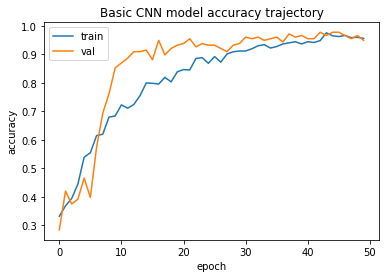

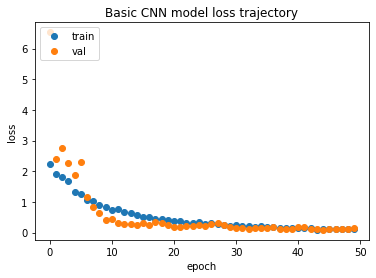

In [9]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(basic_cnn_model_results.history['accuracy'])
plt.plot(basic_cnn_model_results.history['val_accuracy'])
plt.title('Basic CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(basic_cnn_model_results.history['loss'],'o')
plt.plot(basic_cnn_model_results.history['val_loss'],'o')
plt.title('Basic CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## (vii)(CNN) Testing the performance of the basic CNN model on the held out test set

In [10]:
## Testing the basic CNN model

cnn_score = basic_cnn_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the basic CNN model:',cnn_score[1])
print(x_test.shape)
print(y_test.shape)

Test accuracy of the basic CNN model: 0.5600000023841858
(200, 250, 1, 22)
(200, 4)
